In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

from thinkbayes import Pmf
from thinkbayes import Suite
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# 추정

## 1. 주사위 문제

> 베이지안 접근법
> 1. 가설을 나타내자
> 2. 데이터를 나타내자
> 3. 우도함수를 작성하자

>- 예제
>- 4면체, 6면체, 8면체, 12면체, 20면체 주사위가 든 상자가 있음
>- 상자에서 주사위 하나를 집어 던졌더니 6이 나옴
>- 각 주사위를 선택했을 확률은 어떻게 될까?


$1$. 가설 설정


- 선택한 주사위는 4면체, 6면체, 8면체, 12면체, 20면체 중 하나이다

In [2]:
hypotheses = [4, 6, 8, 12, 20]

$2$. 데이터를 나타내자


- 데이터는 4면체부터 20면체까지의 주사위에서 나올수 있는 숫자들이고, range(1,21)로 모두 정의할 수 있음
- 이 경우 4면체에서는 5부터 20까지의 데이터는 무시됨

$3$. 우도함수를 작성하자

- 주사위를 굴려 특정 값이 나올 확률은 "1/주사위크기"로 나타낼 수 있음
- 위 가설에서는 "1/가설명"으로 나타낼 수 있음
- 단, 주사위 크기보다 큰 값이 나올 확률은 0임

In [3]:
def likelihood(self, data, hypo):
    if data > hypo:
        return 0
    else:
        return 1/hypo

- 위 과정을 class로 구현하자면 아래와 같음

In [4]:
class Dice(Suite):
    
    def Likelihood(self, data, hypo):
        if data > hypo:
            return 0
        else:
            return 1/hypo

In [5]:
suite = Dice(hypotheses)
suite.d

{4: 0.2, 6: 0.2, 8: 0.2, 12: 0.2, 20: 0.2}

In [6]:
suite.Update(6)
suite.d

{4: 0.0,
 6: 0.3921568627450981,
 8: 0.29411764705882354,
 12: 0.19607843137254904,
 20: 0.11764705882352944}

- 4면체를 골랐을 확률은 0% (6이 나올 수 없으므로), 6면체를 골랐을 확률은 39%, 8면체를 골랐을 확률은 29%, 12면체를 골랐을 확률은 20%, 20면체를 골랐을 확률은 12%임

- 만약 몇번 더 굴려서 11, 9, 4, 3이 나왔다면 아래와 같이 확률을 계산 가능

In [7]:
for i in [11, 9, 4, 3]:
    suite.Update(i)

suite.d

{4: 0.0, 6: 0.0, 8: 0.0, 12: 0.9278503562945368, 20: 0.07214964370546323}

___
## 2. 기관차 문제



$"Fifty\ Challenging\ Problems\ in\ Probability\ with\ Solutions"$
- 각 철도는 1부터 $N$까지의 순서로 번호를 붙임
- 어느 날 60호 기관차를 발견
- 이 철도에는 몇개의 기관차가 지나갈 지 추측

베이지안 추론법에 따르면 아래 2단계로 문제를 해결
>1. $N$에 대해 알고 있는 것이 무엇인가?  - __사전확률__
>2. $N$에 어떤 값이 주어질 때 관측값의 우도는 어떻게 되는가? -__우도__

- 현 상황에서 사전확률에 대한 근거는 부족
- 따라서 __간단한 가정으로 시작하여 보완해가는 방법__을 차용

- $N$은 1부터 1000까지 어떤 값이든지 될 수 있음

In [8]:
hypos = range(1,1001)

- 우도함수는 주사위 문제와 동일

In [9]:
class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1/hypo

In [10]:
suite = Train(hypos)
suite.Update(60)

0.0028222671142652746

- 주사위 문제와 동일한 방식으로 갱신 시 결과 값은 60에서 가장 가능성이 높게 나옴 *(당연)*

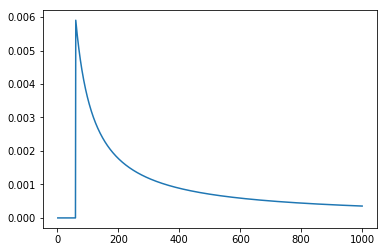

In [11]:
pd.Series(suite.d, index = suite.d.keys()).plot()

- 사후평균(MMSE)은 333이며, 이를 최소화 하는 방향으로 조절해 나아갈 필요가 있음

In [12]:
suite.Mean()

333.41989326371095

___
## 3. 사전 확률로 할 수 있는 것

- 합리적인 경우라면 1000보다 많거나 적게 추측할 수도 있음
- MMSE를 최소화하는 추측이라면 60이 답이 될 수도 있음
- 하지만 이런 추론은 좋지 않으며, 2가지 방식으로 합리적인 추론을 할 수 있음
> ### 1. 데이터를 더 확보할 것
> ### 2. 배경 지식을 더 확보할 것

예를 들어 60호 외 30호와 90호 기관차도 보았다면, 분포를 아래와 같이 갱신 가능

In [13]:
suite = Train(range(1,1001))
for data in [60, 30, 90]:
    suite.Update(data)

suite.Mean()

164.3055864227336

In [14]:
MMSE = pd.DataFrame({'기관차 수': [500, 1000, 2000], '60호만 볼 경우': [0, 0, 0], '추가 관측': [0, 0, 0]}).iloc[:,[1,0,2]]

n = 0
for i in [range(1,501),range(1,1001), range(1,2001)]:
    suite = Train(i)
    suite.Update(60)
    MMSE.iloc[n,1] = round(suite.Mean(),0)
    for data in [30, 90]:
        suite.Update(data)
    MMSE.iloc[n,2] = round(suite.Mean(),0)
    n += 1

MMSE

,기관차 수,60호만 볼 경우,추가 관측
0,500,207.0,152.0
1,1000,333.0,164.0
2,2000,552.0,171.0


- 데이터가 더 확보된다면, 사후확률의 MSE는 차이가 더 작아짐

___
## 4. 사전확률의 대안
- 데이터를 더 확보할 수 없다면, 배경지식을 바탕으로 사전확률을 개선하는 방식이 있음
- 예를 들어, 1000대의 기관차를 운영하는 회사가 세상에 하나뿐이라고 가정하는 것은 비합리적일 수 있음
- 관측 데이터에서 철도 회사 목록을 찾을 수도 있고, 전문가와 인터뷰 할 수도 있음
- 철도 경제에 특화된 정보 수집 없이도 학습된 추측을 할 수 있으며, 본 케이스에서는 **"로버트 액스텔의 멱법칙 (Power-Law Distribution)"**을 따른다는 가정하에 추정을 수행

- 멱법칙의 그래프와 함수는 아래와 같음

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Long_tail.svg/1000px-Long_tail.svg.png)

$$
f(x) = kx^{-\alpha,}
$$
>where:  
>$x =$ variable  
>$\alpha =$ law's exponent  
>$k =$ constant

- 본 문제에서는 $k$와 $a$를 1로(1에 가깝게) 설정

In [15]:
class Train_PL(Dice):
    
    def __init__(self, hypos, alpha = 1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))    #### self.d[x] = y
        self. Normalize()   

In [16]:
hypos = np.arange(1, 1001)
suite = Train_PL(hypos)
suite.d

{1: 0.13359213049244018,
 2: 0.06679606524622009,
 3: 0.044530710164146725,
 4: 0.033398032623110044,
 5: 0.026718426098488037,
 6: 0.022265355082073363,
 7: 0.019084590070348597,
 8: 0.016699016311555022,
 9: 0.014843570054715574,
 10: 0.013359213049244019,
 11: 0.01214473913567638,
 12: 0.011132677541036681,
 13: 0.010276317730187706,
 14: 0.009542295035174298,
 15: 0.008906142032829346,
 16: 0.008349508155777511,
 17: 0.007858360617202364,
 18: 0.007421785027357787,
 19: 0.007031164762760009,
 20: 0.006679606524622009,
 21: 0.006361530023449532,
 22: 0.00607236956783819,
 23: 0.005808353499671312,
 24: 0.005566338770518341,
 25: 0.005343685219697607,
 26: 0.005138158865093853,
 27: 0.004947856684905191,
 28: 0.004771147517587149,
 29: 0.004606625189394488,
 30: 0.004453071016414673,
 31: 0.004309423564272263,
 32: 0.0041747540778887555,
 33: 0.004048246378558793,
 34: 0.003929180308601182,
 35: 0.0038169180140697192,
 36: 0.0037108925136788936,
 37: 0.0036105981214173024,
 38: 0.003

In [17]:
MMSE = pd.DataFrame({'기관차 수': [500, 1000, 2000],
                     '60호만 볼 경우': [0, 0, 0],
                     '추가 관측': [0, 0, 0],
                     '멱함수': [0,0,0],
                    '멱함수 추가 관측': [0, 0, 0]}).iloc[:,[1,0,4,2, 3]]

n = 0
for i in [range(1,501),range(1,1001), range(1,2001)]:
    suite = Train(i)
    suite.Update(60)
    MMSE.iloc[n,1] = round(suite.Mean(),0)
    
    for data in [30, 90]:
        suite.Update(data)
    MMSE.iloc[n,2] = round(suite.Mean(),0)
    
    suite_PL = Train_PL(i)
    suite_PL.Update(60)
    MMSE.iloc[n,3] = round(suite_PL.Mean(),0)
    
    for data in [30, 90]:
        suite_PL.Update(data)
    MMSE.iloc[n,4] = round(suite_PL.Mean(),0)
    
    n += 1

MMSE

,기관차 수,60호만 볼 경우,추가 관측,멱함수,멱함수 추가 관측
0,500,207.0,152.0,144.0,131.0
1,1000,333.0,164.0,179.0,133.0
2,2000,552.0,171.0,216.0,134.0


- 사후확률의 평균값은 큰 상한값으로 갈 수록 134에 수렴
- 따라서 회사 규모에 대한 일반적인 정보 기반으로 한 멱법칙 사전확률이 보다 현실적이고 잘 작용할 것

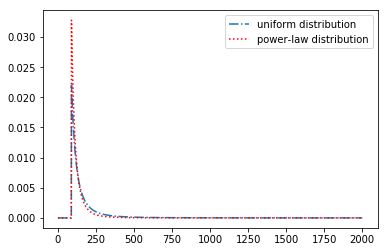

In [18]:
pd.Series(suite.d, index = suite.d.keys()).plot(ls = '-.', label = 'uniform distribution')
pd.Series(suite_PL.d, index = suite_PL.d.keys()).plot(ls = ':', color = 'red', label = 'power-law distribution')
legend()

- 멱법칙과 균등분포 별 사후확률을 비교해 보면, 멱법칙을 사용한 경우가 더 정교하게 추정하는 것을 볼 수 있음

___
## 5. 신뢰구간

- 평균, 중간값, 최대우도값을 사용하는 점추정과 달리, 구간 추정은 미확인 값이 어느 구간 사이에 올 확률이 90%(또는 다른 확률) 인 구간을 추정
- 신뢰구간을 계산하는 간단한 방법은 사후확률이 5%와 95%에 해당하는 값을 찾는 것
- thinkbayes에서는 아래와 같은 함수로 신뢰구간(구간추정)을 제공:

In [20]:
def Percentile(pmf, percentage):
    p = percentage / 100
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total >= p:
            return val

In [21]:
interval = Percentile(suite_PL, 5), Percentile(suite_PL, 95)
interval

(91, 243)

> 멱법칙의 사전확률을 따르고 60호 외 30호와 90호 기관차를 관측하였을 경우, 약 90% 확률로 기관차는 91개에서 243개가 있을 수 있음

___
## 6. 누적분포함수

- 단순히 신뢰구간을 구하는 것을 넘어서서, 분위 수 이상을 계산해야 하는 경우라면 "누적분포함수"나 Cdf를 사용하는 것이 효과적
- thinkbayes에서는 Pmf에서 이에 대응하는 Cdf 함수를 제공

In [27]:
cdf = suite_PL.MakeCdf()
interval2 = cdf.Percentile(5), cdf.Percentile(95)
interval2

(91, 243)